## Construct line graph from toy example
- Check python kernel and import graph construction libraries

In [ ]:
import sys, platform
print(sys.executable)
print(platform.python_version())
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


c:\Users\andre\miniconda3\python.exe
3.12.3


- Read toy data

In [144]:
NODES_CSV = "nodes_temperatures_csv__preview_.csv"
EDGES_CSV = "edges_delays_csv__preview_.csv"
nodes_df = pd.read_csv(NODES_CSV)
edges_df = pd.read_csv(EDGES_CSV)
print(nodes_df[0:10])
print(edges_df[0:10])

   t  node  temperature
0  0     0            1
1  0     1           16
2  0     2           13
3  0     3            9
4  0     4            9
5  0     5           18
6  1     0            1
7  1     1           14
8  1     2            4
9  1     3            1
   t  u  v  delay
0  0  0  1    8.5
1  0  1  2   14.5
2  0  2  3   11.0
3  0  3  4    9.0
4  0  4  5   13.5
5  0  5  0    9.5
6  1  0  1    7.5
7  1  1  2    9.0
8  1  2  3    2.5
9  1  3  4    6.0


#### Construct normal graph

In [299]:
def make_graph(nodes_df, edges_df, t_snapshot):
    nodes = nodes_df[nodes_df['t'] == t_snapshot]
    edges = edges_df[edges_df['t'] == t_snapshot]
    node_features = []
    G = nx.Graph()
    for node, temperature in nodes[["node","temperature"]].values:
        node_features.append((int(node),{"temperature":temperature}))
    G.add_nodes_from(node_features)
    links = []
    for u,v,delay in edges[['u','v','delay']].values:
        links.append((int(u),int(v),{'delay':delay}))
    G.add_edges_from(links)
    
    return G


In [300]:
t_snapshot = 0
G = make_graph(nodes_df, edges_df, t_snapshot)

#### Construct line graph from normal graph

In [301]:
def make_linegraph(G):
    LG = nx.line_graph(G)
    for (u,v) in LG.nodes:
        LG.nodes[u,v]['delay'] = G.edges[u,v]['delay']
    for node_u, node_v in LG.edges:
        s = (set(node_u) & set(node_v)).pop()
        LG.edges[node_u, node_v]['temperature'] = G.nodes[s]['temperature']
    return LG

#### Plot normal graph + line graph

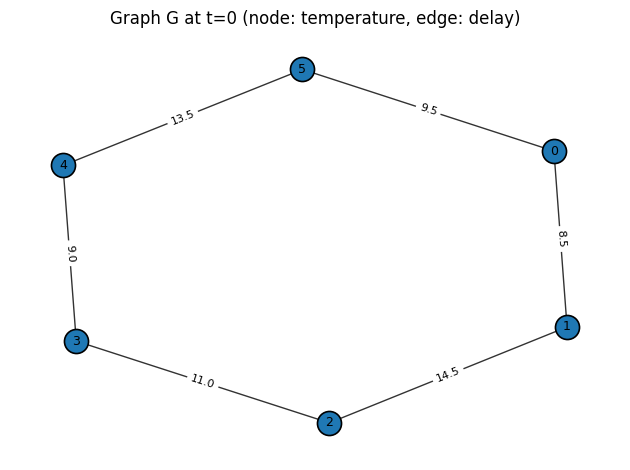

node 0, {'temperature': np.int64(1)}
node 1, {'temperature': np.int64(16)}
node 2, {'temperature': np.int64(13)}
node 3, {'temperature': np.int64(9)}
node 4, {'temperature': np.int64(9)}
node 5, {'temperature': np.int64(18)}


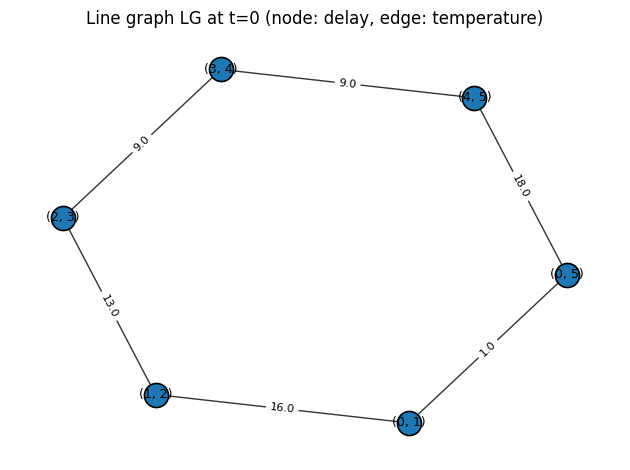

node (0, 1), {'delay': np.float64(8.5)}
node (0, 5), {'delay': np.float64(9.5)}
node (1, 2), {'delay': np.float64(14.5)}
node (2, 3), {'delay': np.float64(11.0)}
node (4, 5), {'delay': np.float64(13.5)}
node (3, 4), {'delay': np.float64(9.0)}


In [302]:
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, edgecolors="black", linewidths=1.2)
nx.draw_networkx_edges(G, pos, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edge_labels(G, pos,
    edge_labels={e: f"{w:.1f}" for e, w in nx.get_edge_attributes(G, "delay").items()},
    font_size=8
)

plt.title(f"Graph G at t={t_snapshot} (node: temperature, edge: delay)")
plt.axis("off")
plt.tight_layout()
plt.show()

for node in G.nodes:
    print(f"node {node}, {G.nodes[node]}")

LG = make_linegraph(G)

posL = nx.spring_layout(LG, seed=42)

nx.draw_networkx_nodes(LG, posL, edgecolors="black", linewidths=1.2)
nx.draw_networkx_edges(LG, posL, alpha=0.8)
# label LG nodes with the original edges, e.g. "(0, 1)"
nx.draw_networkx_labels(LG, posL, labels={n: str(n) for n in LG.nodes()}, font_size=9)
nx.draw_networkx_edge_labels(
    LG, posL,
    edge_labels={(u,v): f"{w:.1f}" for (u,v),w in nx.get_edge_attributes(LG, "temperature").items()},
    font_size=8
)


plt.title(f"Line graph LG at t={t_snapshot} (node: delay, edge: temperature)")
plt.axis("off")
plt.tight_layout()
plt.show()

for node in LG.nodes:
    print(f"node {node}, {LG.nodes[node]}")
    

In [321]:
print(G.nodes())
print(G.edges)
print(LG.nodes())
print(LG.edges)

[0, 1, 2, 3, 4, 5]
[(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)]
[(0, 1), (0, 5), (1, 2), (2, 3), (4, 5), (3, 4)]
[((0, 1), (0, 5)), ((0, 1), (1, 2)), ((0, 5), (4, 5)), ((1, 2), (2, 3)), ((2, 3), (3, 4)), ((4, 5), (3, 4))]


#### Check if both graphs are consistent

In [322]:
for edge in G.edges:
    if G.edges[edge]['delay'] != LG.nodes[edge]['delay']:
        print("edge -> node mappiing wrong!")
for edge in LG.edges:
    s = (set(edge[0]) & set(edge[1])).pop()
    if LG.edges[edge]['temperature'] != G.nodes[s]['temperature']:
        print("node -> edge mapping wrong!")

## GCN + RNN


In [372]:
from torch_geometric.utils import from_networkx, to_undirected
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- Data preparation for GCN + RNN
- Mean temperature as feature vector

In [346]:
node2idx = {n:i for i,n in enumerate(LG.nodes())}
idx2node = {i:n for i,n in enumerate(LG.nodes())}
print(node2idx)
print(idx2node)

{(0, 1): 0, (0, 5): 1, (1, 2): 2, (2, 3): 3, (4, 5): 4, (3, 4): 5}
{0: (0, 1), 1: (0, 5), 2: (1, 2), 3: (2, 3), 4: (4, 5), 5: (3, 4)}


In [376]:
def linegraph_to_pyg(LG, default_edge_weight = 1.0):
    X = []
    Y = []
    # [LG.nodes[idx[i]]["delay"] for i in idx]
    for node in node2idx:
        feature_vector = []
        mean_temp = 0
        for (u, v) in LG.edges:
            if node == u or node == v:
                mean_temp = mean_temp + LG.edges[(u,v)]["temperature"]
        mean_temp = mean_temp / 2
        feature_vector.append(mean_temp)
        X.append(feature_vector)
        Y.append(LG.nodes[node]["delay"])
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    idx_pairs = []
    edge_weights = []
    for (u, v) in LG.edges():
        idx_pairs.append((node2idx[u], node2idx[v]))
        edge_weights.append(default_edge_weight)
        idx_pairs.append((node2idx[v], node2idx[u]))
        edge_weights.append(default_edge_weight)
    edge_index = torch.tensor(idx_pairs, dtype=torch.long).t().contiguous()
    edge_weights = torch.full((edge_index.size(1),), 1.0, dtype=torch.float32)

    return X, Y, edge_index, edge_weights

In [377]:
X_seq = []
Y_seq = []
edge_index = []
edge_weights = []
for t_snapshot in range(10):
    G = make_graph(nodes_df, edges_df, t_snapshot)
    LG = make_linegraph(G)
    X, Y, edge_index, edge_weights = linegraph_to_pyg(LG)
    X_seq.append(X)
    Y_seq.append(Y)
X_seq = torch.stack(X_seq)
Y_seq = torch.stack(Y_seq)
X_seq.to(dtype=torch.float32, device=device)
edge_index = edge_index.to(dtype=torch.long, device=device)
edge_weights = edge_weights.to(dtype=torch.float32, device=device)

print(X_seq.shape)
print(Y_seq.shape)

torch.Size([10, 6, 1])
torch.Size([10, 6])


- Very simple GCN encoder

In [386]:
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

- GCN + RNN Class

In [383]:
class GCN_RNN(nn.Module):
    def __init__(self, in_channels, gcn_hidden, rnn_hidden=64):
        super().__init__()
        self.gcn = GCNEncoder(in_channels, gcn_hidden)
        self.gru = nn.GRU(input_size=gcn_hidden, hidden_size=rnn_hidden, num_layers=1)
        self.out = nn.Linear(rnn_hidden, 1)

    def forward(self, X_seq, edge_index, edge_weight):
        # for all graphs_0 ... graph_t
        H_t = []
        for x in X_seq:
            # get the embeddings at t
            h = self.gcn(x, edge_index, edge_weight)
            # stack all the embeddings 
            H_t.append(h)
        H = torch.stack(H_t, dim=0)
        print(H.shape)
        
        # RNN on embedding sequence
        H_gru, _ = self.gru(H)
        # summarized state i.e the last state
        last = H_gru[-1]
        # from embeddings to prediction
        y = self.out(last)
        return y

In [ ]:
gcn_hidden = 32
rnn_hidden = 32

model = GCN_RNN(in_channels=1, gcn_hidden=gcn_hidden, rnn_hidden=rnn_hidden)
# optim = torch.optim.Adam(model.parameters(), lr=1e-3)
x = X_seq[0]
print(x.shape)
test = model(x, edge_index, edge_weights)
# forward + loss
# y_pred = model(X_seq, edge_index, edge_weights)
# loss = F.mse_loss(y_pred, Y)

# optim.zero_grad()
# loss.backward()
# optim.step()

# print("y_pred shape:", y_pred.shape, "loss:", float(loss.item()))

torch.Size([6, 1])
torch.Size([6, 32])
torch.Size([6, 32])
